# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import scipy.sparse as sparse
from scipy.stats import chi2_contingency

In [2]:
# Loading the datasets
train = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
sample = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv")
movies = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

In [3]:
# Extract features and target variable from training data
x = train.iloc[:, :-1]
y = train["sentiment"]
y = y.apply(lambda x: 1 if x == "POSITIVE" else 0)

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [4]:
# Merging training and movies datasets on 'movieid' along with 'ytrain'
merged_data = pd.merge(xtrain, ytrain, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, movies, on='movieid', how='inner')

In [5]:
# Displaying basic information about the training data
print(merged_data.shape)
print(merged_data.info())

# Displaying basic statistics of the training data
print(merged_data.describe())

(367934, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 367934 entries, 0 to 367933
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               367934 non-null  object 
 1   reviewerName          367934 non-null  object 
 2   isFrequentReviewer    367934 non-null  bool   
 3   reviewText            350533 non-null  object 
 4   sentiment             367934 non-null  int64  
 5   title                 367934 non-null  object 
 6   audienceScore         157154 non-null  float64
 7   rating                94091 non-null   object 
 8   ratingContents        94091 non-null   object 
 9   releaseDateTheaters   127699 non-null  object 
 10  releaseDateStreaming  174638 non-null  object 
 11  runtimeMinutes        211903 non-null  float64
 12  genre                 215645 non-null  object 
 13  originalLanguage      213432 non-null  object 
 14  director              367934 non-null  

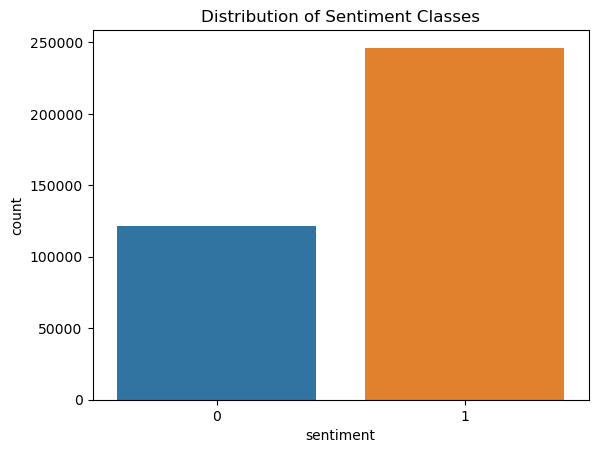

In [6]:
# Visualizing the distribution of sentiment classes
sns.countplot(x='sentiment', data=merged_data)
plt.title('Distribution of Sentiment Classes')
plt.show()

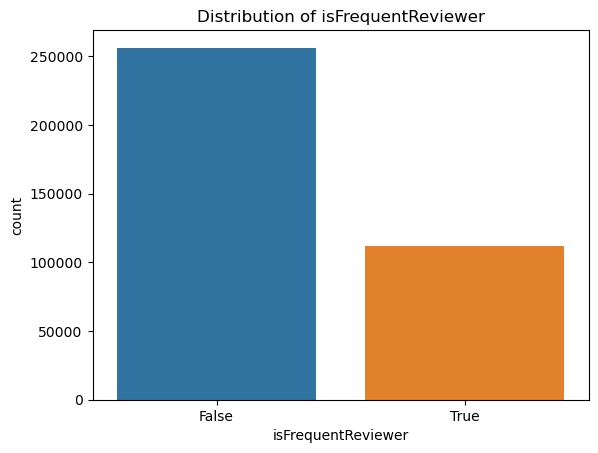

In [7]:
# Visualizing the distribution of 'isFrequentReviewer'
sns.countplot(x='isFrequentReviewer', data=merged_data)
plt.title('Distribution of isFrequentReviewer')
plt.show()

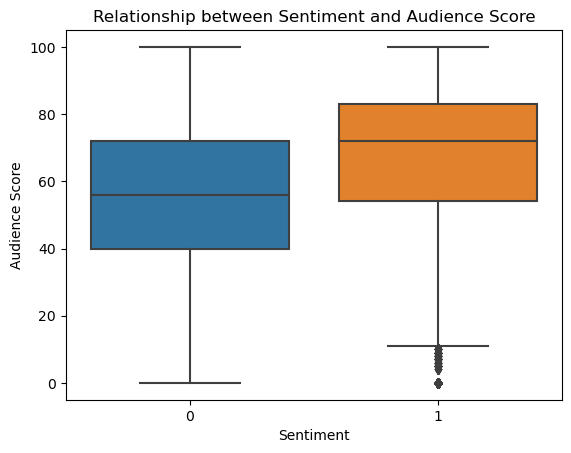

In [8]:
# Visualizing the relationship between 'audienceScore' and 'sentiment'

sns.boxplot(data=merged_data, x='sentiment', y='audienceScore')
plt.title('Relationship between Sentiment and Audience Score')
plt.xlabel('Sentiment')
plt.ylabel('Audience Score')
plt.show()

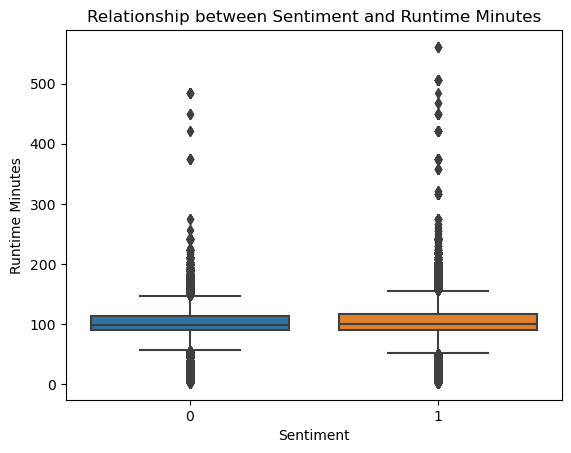

In [9]:
# Visualizing the relationship between 'runtimeMinutes' and 'sentiment'

sns.boxplot(data=merged_data, x='sentiment', y='runtimeMinutes')
plt.title('Relationship between Sentiment and Runtime Minutes')
plt.xlabel('Sentiment')
plt.ylabel('Runtime Minutes')
plt.show()

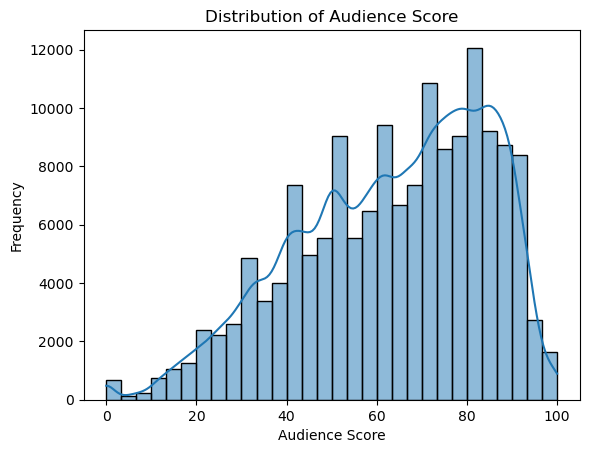

In [10]:
# Visualizing the distribution of 'audienceScore'

sns.histplot(data=merged_data, x='audienceScore', bins=30, kde=True)
plt.title('Distribution of Audience Score')
plt.xlabel('Audience Score')
plt.ylabel('Frequency')
plt.show()

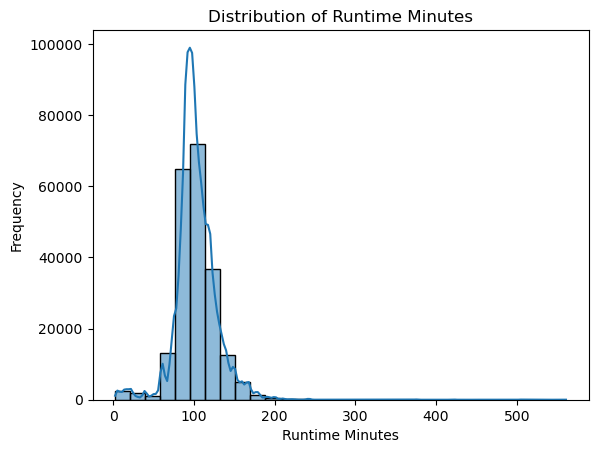

In [11]:
# Visualizing the distribution of 'runtimeMinutes'

sns.histplot(data=merged_data, x='runtimeMinutes', bins=30, kde=True)
plt.title('Distribution of Runtime Minutes')
plt.xlabel('Runtime Minutes')
plt.ylabel('Frequency')
plt.show()

**'audienceScore' is left skewed and 'runtimeMinutes' is right skewed which suggests for l2 or l1 regularizations.**

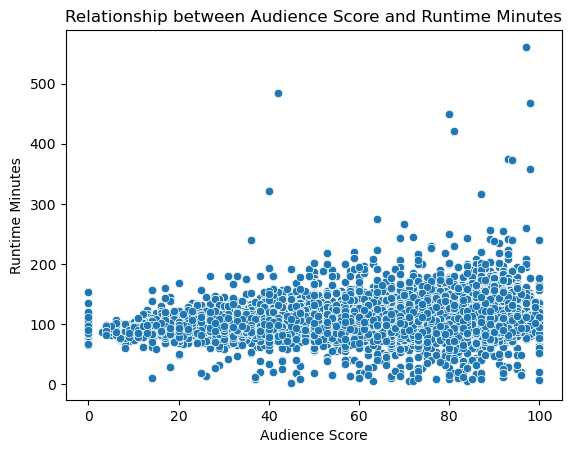

In [12]:
# Visualizing the relationship between 'audienceScore' and 'runtimeMinutes'

sns.scatterplot(data=merged_data, x='audienceScore', y='runtimeMinutes')
plt.title('Relationship between Audience Score and Runtime Minutes')
plt.xlabel('Audience Score')
plt.ylabel('Runtime Minutes')
plt.show()

Chi-Squared Test for isFrequentReviewer:
Chi-Squared Value: 1737.2098265489049
P-Value: 0.0



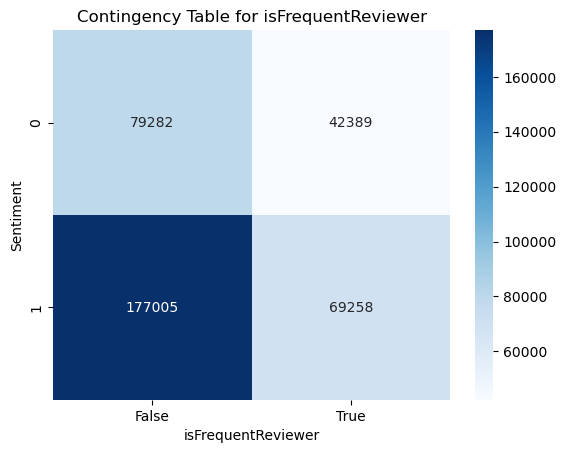

Chi-Squared Test for rating:
Chi-Squared Value: 441.38366198986915
P-Value: 3.5094076565594564e-92



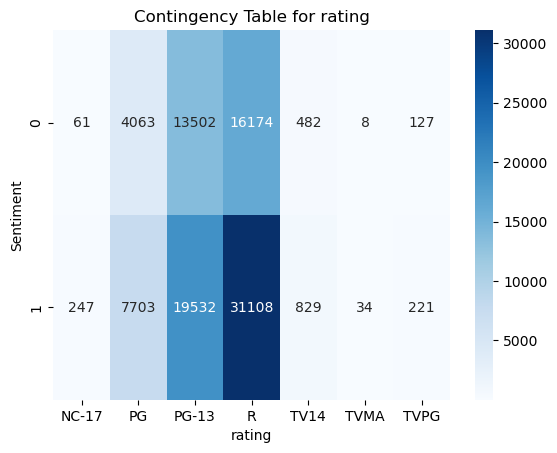

Chi-Squared Test for originalLanguage:
Chi-Squared Value: 1461.7489890515005
P-Value: 1.6105453931321909e-243



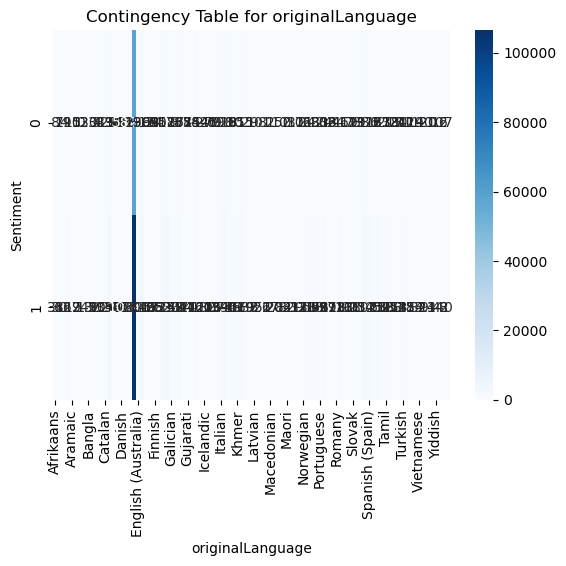

In [13]:
categorical_variables = ['isFrequentReviewer', 'rating', 'originalLanguage']

# Perform chi-squared test for each categorical variable
for var in categorical_variables:
    contingency_table = pd.crosstab(merged_data['sentiment'], merged_data[var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Squared Test for {var}:")
    print(f"Chi-Squared Value: {chi2}")
    print(f"P-Value: {p}")
    print("")
    
    # Visualizing contingency table
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Contingency Table for {var}")
    plt.xlabel(var)
    plt.ylabel("Sentiment")
    plt.show()

**The above result shows that isFrequentReviewer has high dependency and the lower pvalue shows that it is unlikely to have occurred by chance. Other columns have higher pvalue hence wouldn't be taken for modelling**

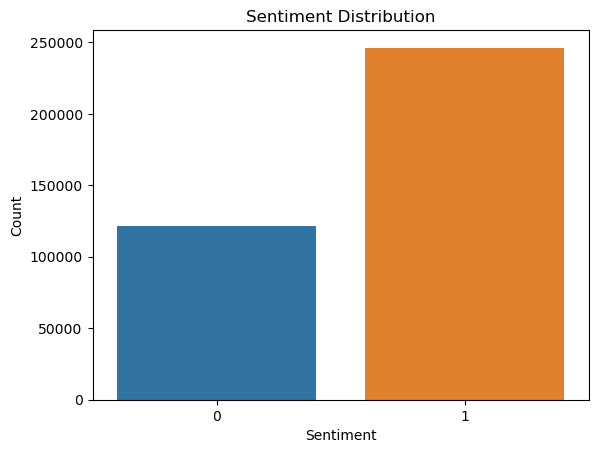

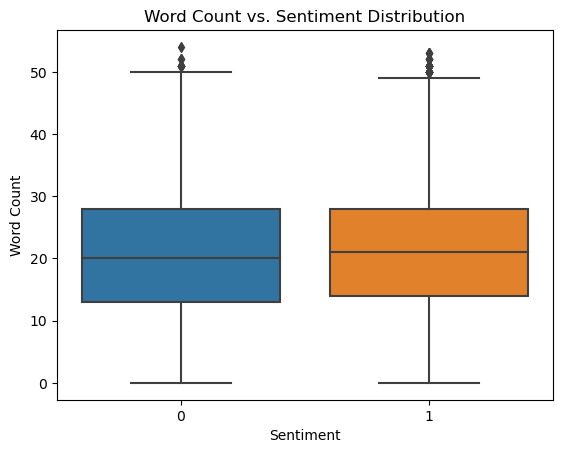

In [14]:
# Replacing NaN values with an empty string
merged_data['reviewText'] = merged_data['reviewText'].fillna('')

# Defining a function to calculate word count
def get_word_count(text):
    return len(text.split())

# Applying the function to create the 'word_count' column
merged_data['word_count'] = merged_data['reviewText'].apply(get_word_count)

# sentiment distribution

sns.countplot(x='sentiment', data=merged_data)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# word count vs sentiment box plot

sns.boxplot(x='sentiment', y='word_count', data=merged_data)
plt.title("Word Count vs. Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()

In [15]:
# !pip install --upgrade scikit-learn

In [16]:
# Vectorizing reviewText using CountVectorizer

vec = CountVectorizer(binary=True,ngram_range=(1,3), stop_words='english')
xtrain["reviewText"].replace(np.nan, "", inplace=True)
vecfit = vec.fit_transform(xtrain["reviewText"])

In [17]:
# Preparing movie-related features

# Calculating the maximum audience score per movie
movie = movies.groupby("movieid").agg({"audienceScore": lambda x: np.max(x.dropna())})
newm = movie.reset_index()
newm["audienceScore"].replace(np.nan, np.mean(newm["audienceScore"]), inplace=True)

In [18]:
# Calculating the average runtimeMinutes per movie
movr = movies.groupby("movieid").agg({"runtimeMinutes": lambda x: np.mean(x.dropna())})
newmr = movr.reset_index()
newmr["runtimeMinutes"].replace(np.nan, newmr["runtimeMinutes"].mean(), inplace=True)
newmr["runtimeMinutes"] = newmr["runtimeMinutes"].apply(lambda x: int(x))

In [19]:
# Mergeing movie-related features with training data
merged = xtrain.merge(newm, how='left', on='movieid')
merged = merged.merge(newmr, how='left', on='movieid')
merged["isFrequentReviewer"] = merged["isFrequentReviewer"].apply(lambda x: 0 if x == False else 1)

In [20]:
# Creating a feature matrix by combining different features
import scipy.sparse as sparse
vect = sparse.hstack((merged["audienceScore"].to_numpy()[:, None], vecfit))
vect = sparse.hstack((merged["isFrequentReviewer"].to_numpy()[:, None], vect))

In [21]:
# Scaling the feature matrix using MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
vectf = mas.fit_transform(vect)

In [22]:
# Training a Logistic Regression model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None, solver='saga', random_state=42)
lr.fit(vectf, ytrain)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [23]:
lr.n_iter_

array([2324], dtype=int32)

In [24]:
# Preparing test data and making predictions

# Preparing test data for vectorization and feature scaling
xtest["reviewText"].replace(np.nan, "", inplace=True)
ser = vec.transform(xtest['reviewText'])
testmerged = xtest.merge(newm, how='left', on='movieid')
testmerged["isFrequentReviewer"] = testmerged["isFrequentReviewer"].apply(lambda x: 1 if x == True else 0)

# Creating a feature matrix for test data
servec = sparse.hstack((testmerged["audienceScore"].to_numpy()[:, None], ser))
servec = sparse.hstack((testmerged["isFrequentReviewer"].to_numpy()[:, None], servec))
servect = mas.transform(servec)

# Making predictions using the trained model
ypred = lr.predict(servect)

# Evaluating the model's performance
print(lr.score(servect, ytest))
print(f1_score(ytest, ypred))

0.8018145326452035
0.8541676085416762


In [25]:
from sklearn.metrics import classification_report
classification_report(ytest,ypred)

'              precision    recall  f1-score   support\n\n           0       0.72      0.67      0.69     16201\n           1       0.84      0.87      0.85     32627\n\n    accuracy                           0.80     48828\n   macro avg       0.78      0.77      0.77     48828\nweighted avg       0.80      0.80      0.80     48828\n'

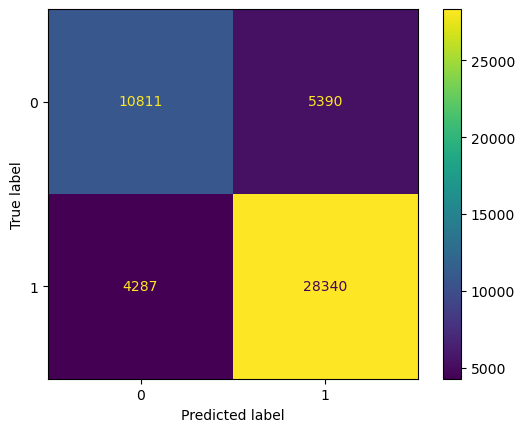

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(ytest,ypred)

In [27]:
lr.coef_

array([[-0.10082301,  4.67010475,  0.47494282, ...,  0.12584919,
         0.12584919,  0.12584919]])

In [28]:
lr.intercept_

array([-3.27080822])

In [29]:
# # hyper parameter tuning
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C':[0.1,1,10],
#               'penalty':['l2',"elasticnet","l1","none"],
#               'solver':['saga','liblinear','sag'],
#               'max_iter':[500,1000,5000],
#               'tol':[0.001,0.01,0.1]              
#               }
# gridsearch = GridSearchCV(lr,param_grid,scoring='f1',cv=3)              
# gridsearch.fit(vectf, ytrain)
# gridsearch.best_estimator_
# LogisticRegression(C=10, class_weight='balanced', max_iter=5000, penalty='none',solver='saga', tol=0.01)
# 0.8235848283771606
# 0.8680574702080078
# LogisticRegression(C=10, class_weight='balanced', max_iter=1000, penalty='none',solver='saga', tol=0.01)
# 0.828172360121242
# 0.8716261705122712
# 6hr

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [31]:
test["reviewText"].replace(np.nan,"",inplace=True)
ser=vec.transform(test['reviewText'])
testmerged=test.merge(newm,how='left',on='movieid')
testmerged["isTopCritic"]=testmerged["isTopCritic"].apply(lambda x:1 if x==True else 0)

servec=sparse.hstack((testmerged["audienceScore"].to_numpy()[:,None],ser))
servec=sparse.hstack((testmerged["isTopCritic"].to_numpy()[:,None],servec))
servect=mas.transform(servec)
ypred = lr.predict(servect)

In [32]:
ycol = np.where(ypred == 1, "POSITIVE", "NEGATIVE")

In [33]:
sub = pd.DataFrame(ycol, columns=['sentiment'])
sub.index.name = 'id'
sub.to_csv("submission.csv", encoding='utf-8')

output = pd.read_csv("submission.csv")

In [34]:
# # # LogReg with different scaling and imputing
# from sklearn.impute import SimpleImputer
# si=SimpleImputer(strategy='most_frequent')
# x=si.fit_transform(train['reviewText'].values.reshape(-1,1)).flatten()
# y=train['sentiment']
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(max_features=1000)
# X = vectorizer.fit_transform(x)
# # vocabulary = vectorizer.get_feature_names()
# # df = pd.DataFrame(X.toarray(), columns=vocabulary)

# from sklearn.preprocessing import OrdinalEncoder
# y=OrdinalEncoder().fit_transform(y.values.reshape(-1,1)).flatten()
# from sklearn.model_selection import train_test_split
# xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state=0,test_size=0.2)

# from sklearn.linear_model import LogisticRegression
# lr=LogisticRegression(max_iter=300)
# model=lr.fit(xtrain,ytrain)
# # niters = lr.n_iter_
# # # print(niters)
# # ypredtest = lr.predict(xtest)
# # ypredtrain = lr.predict(xtrain)


# # # from sklearn.metrics import precision_score
# # # p = precision_score(ytest, ypredtest)
# # # print("precision:", p) precision: 0.7610775625441142

# # from sklearn.metrics import f1_score
# # f1 = f1_score(ytest, ypredtest)
# # # print("f1 test:",f1) f1 test: 0.8219798835362626

# # f1 = f1_score(ytrain, ypredtrain)
# # # print("f1 train:",f1) f1 train: 0.827404284170604

# x=test["reviewText"]
# x=si.transform(x.values.reshape(-1,1)).flatten()
# x=vectorizer.transform(x)
# x=lr.predict(x)
# x=np.where(x==1,"POSITIVE","NEGATIVE")

# sub = pd.DataFrame(x, columns=['sentiment'])
# sub.index.name = 'id'
# sub.to_csv("submission.csv", encoding='utf-8')

# output = pd.read_csv("submission.csv")
# # score = 0.74307

In [35]:
# # XGBClassifier
# from xgboost import XGBClassifier
# xg=XGBClassifier(n_estimators=500,learning_rate=0.6,colsample_bytree=0.8,max_depth=20)
# xg.fit(vectf, ytrain)
# print(xg.score(xtest,ytest))

# print(xg.feature_importances_)
# # from sklearn.model_selection import GridSearchCV
# # param_grid = {
# #     'learning_rate':[0.1,0.5,0.9],
# #     'max_depth':[5,15,25],
# #     'n_estimators':[300,500],
# #     'colsample_bytree':[0.5,1.0]
# # }
# # grids = GridSearchCV(xg,param_grid,cv=3,scoring='f1')
# # grids.fit(vectf, ytrain)
# # print(grids.best_params_)

# test.info()
# test["reviewText"].replace(np.nan,"",inplace=True)
# ser=vec.transform(test['reviewText'])
# testmerged=test.merge(newm,how='left',on='movieid')
# testmerged["isTopCritic"]=testmerged["isTopCritic"].apply(lambda x:1 if x==True else 0)

# servec=sparse.hstack((testmerged["audienceScore"].to_numpy()[:,None],ser))
# servec=sparse.hstack((testmerged["isTopCritic"].to_numpy()[:,None],servec))
# servect=mas.transform(servec)
# ypred = xg.predict(servect)

# ycol = np.where(ypred == 1, "POSITIVE", "NEGATIVE")
# sub = pd.DataFrame(ycol, columns=['sentiment'])
# sub.index.name = 'id'
# sub.to_csv("submission.csv", encoding='utf-8')

# output = pd.read_csv("submission.csv")
# # score = 0.80562 

In [36]:
# # SGDClassifier
# from sklearn.linear_model import SGDClassifier
# sg=SGDClassifier(max_iter=100)
# sg.fit(vectf, ytrain)
# print("iters :" ,sg.n_iter_)
# print(sg.score(xtest,ytest))

# #  from sklearn.model_selection import GridSearchCV
# # param_grid = {
# #     'loss':['hinge','log','perceptron']
# #     'alpha':[0.1,0.01,0.001],
# #     'learning_rate':['optimal','invscaling'],
# # }
# # grids = GridSearchCV(xg,param_grid,cv=3,scoring='f1')
# # grids.fit(vectf, ytrain)
# # print(grids.best_params_)

# print(test.info())
# test["reviewText"].replace(np.nan,"",inplace=True)
# ser=vec.transform(test['reviewText'])
# testmerged=test.merge(newm,how='left',on='movieid')
# testmerged["isTopCritic"]=testmerged["isTopCritic"].apply(lambda x:1 if x==True else 0)

# servec=sparse.hstack((testmerged["audienceScore"].to_numpy()[:,None],ser))
# servec=sparse.hstack((testmerged["isTopCritic"].to_numpy()[:,None],servec))
# servect=mas.transform(servec)
# ypred = sg.predict(servect)

# ycol = np.where(ypred == 1, "POSITIVE", "NEGATIVE")
# sub = pd.DataFrame(ycol, columns=['sentiment'])
# sub.index.name = 'id'
# sub.to_csv("submission.csv", encoding='utf-8')

# output = pd.read_csv("submission.csv")
# print(output)
# score = 0.8201

In [37]:
# # # KNNClassifier
# from sklearn.neighbors import KNeighborsClassifier
# knn=KNeighborsClassifier(n_neighbors=3)
# knn.fit(vectf, ytrain)
# # print(knn.score(xtest,ytest))
# # 0.6643114606373393

# # from sklearn.model_selection import cross_val_score
# # ks=range(1,7)
# # cv_scores = []
# # for k in ks:
# #     knns = KNeighborsClassifier(n_neighbors=k)
# #     scores = cross_val_score(knn, xtrain, ytrain, cv=5, scoring="f1")
# #     cv_scores.append(scores.mean())
# # print(cv_scores)
# # 3hr
# # [0.7461199237674089, 0.7461199237674089, 0.7461199237674089, 0.7461199237674089, 0.7461199237674089, 0.7461199237674089, 0.7461199237674089]

# print(test.info())
# test["reviewText"].replace(np.nan,"",inplace=True)
# ser=vec.transform(test['reviewText'])
# testmerged=test.merge(newm,how='left',on='movieid')
# testmerged["isTopCritic"]=testmerged["isTopCritic"].apply(lambda x:1 if x==True else 0)

# servec=sparse.hstack((testmerged["audienceScore"].to_numpy()[:,None],ser))
# servec=sparse.hstack((testmerged["isTopCritic"].to_numpy()[:,None],servec))
# servect=mas.transform(servec)
# ypred = knn.predict(servect)

# ycol = np.where(ypred == 1, "POSITIVE", "NEGATIVE")
# sub = pd.DataFrame(ycol, columns=['sentiment'])
# sub.index.name = 'id'
# sub.to_csv("submission.csv", encoding='utf-8')

# output = pd.read_csv("submission.csv")
# print(output)

**MODELS**

**1. Logistic Regression:**

   - **Data:** 
     - **Features:** The features include information such as review text, audience score, and whether the reviewer is a frequent reviewer.
     - **Target Variable:** The target variable is the sentiment of the movie review (0 for "NEGATIVE" and 1 for "POSITIVE").

   - **Model:** 
     - **Explanation:** Logistic Regression is a linear classification model that estimates the probability of a binary outcome (sentiment) based on a linear combination of input features.
     - **Role:** Its role is to learn a set of weights (coefficients) for each feature and combine them linearly to make predictions about the probability of a review being positive or negative.

   - **Loss Function:** 
     - **Explanation:** The loss function used is binary cross-entropy (log loss). It measures the dissimilarity between predicted probabilities and actual labels.
     - **Role:** It guides the model during training to minimize the difference between predictions and true labels.

   - **Optimization Procedure/Training:** 
     - **Explanation:** Solver = 'saga,' Penalty = 'None,' Class-Weight = 'balanced.'
     - **Role:** The optimization process adjusts model weights iteratively to minimize the loss. Solver 'saga' is a variant of Stochastic Average Gradient Descent (SAG).

   - **Evaluation:** 
     - **Explanation:** The model's performance is evaluated using accuracy and F1-score.
     - **Role:** These metrics assess the correctness of the model's predictions and its ability to balance precision and recall.

**2. XGBoost (Extreme Gradient Boosting) Classifier:**

   - **Data:** Same as Logistic Regression.

   - **Model:** 
     - **Explanation:** XGBoost is an ensemble model that combines multiple decision trees.
     - **Role:** It combines the predictions of individual trees to make a final prediction.

   - **Loss Function:** 
     - **Explanation:** XGBoost uses gradient boosting with various loss functions, including logistic loss for classification.
     - **Role:** It guides the boosting process to minimize the chosen loss function.

   - **Optimization Procedure/Training:** 
     - **Explanation:** Parameters like the number of estimators, learning rate, and max depth are tuned to optimize model performance.
     - **Role:** These parameters affect how the ensemble of trees is constructed and how they contribute to the final prediction.

   - **Evaluation:** 
     - **Explanation:** The model's performance is evaluated using accuracy.
     - **Role:** It measures the overall correctness of the model's predictions.

**3. Stochastic Gradient Descent (SGD) Classifier:**

   - **Data:** Same as Logistic Regression.

   - **Model:** 
     - **Explanation:** SGD Classifier is a linear classification model.
     - **Role:** It learns linear decision boundaries to separate classes.

   - **Loss Function:** 
     - **Explanation:** Various loss functions are available, such as hinge loss for SVM-like behavior and log loss for logistic regression-like behavior.
     - **Role:** The loss function determines the type of classification behavior.

   - **Optimization Procedure/Training:** 
     - **Explanation:** The model uses stochastic gradient descent with various parameters (e.g., learning rate, regularization).
     - **Role:** These parameters control the gradient descent process during training.

   - **Evaluation:** 
     - **Explanation:** The model's performance is evaluated using accuracy.
     - **Role:** It measures the overall correctness of the model's predictions.

**4. K-Nearest Neighbors (KNN) Classifier:**

   - **Data:** Same as Logistic Regression.

   - **Model:** 
     - **Explanation:** KNN is a non-parametric classification model that classifies data points based on their nearest neighbors.
     - **Role:** It assigns labels based on the majority class among the k-nearest data points.

   - **Loss Function:** 
     - **Explanation:** KNN doesn't have a loss function in the traditional sense; it relies on distance metrics.
     - **Role:** The choice of distance metric (e.g., Euclidean) affects how nearest neighbors are determined.

   - **Optimization Procedure/Training:** 
     - **Explanation:** No explicit training; the model stores the training data and classifies new data points based on their neighbors.
     - **Role:** It classifies new data points based on their similarity to training examples.

   - **Evaluation:** 
     - **Explanation:** The model's performance is evaluated using accuracy.
     - **Role:** It measures the overall correctness of the model's predictions.